In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models, utils
clear_output()

model = models.Sequential([
            # Primary (A1) layers
            # layers.Input(shape=(128, 32, 1)),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='A1_C1'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='A1_C2'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),

            # Belt (A2) layers
            layers.Conv2D(128, (5, 5), activation='relu', padding='same', name='B_C1'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(256, (5, 5), activation='relu', padding='same', name='B_C2'),
            layers.BatchNormalization(),
            layers.GlobalAveragePooling2D(),

            # Parabelt (A3) layers
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.Dense(5, activation='softmax')
])

In [37]:
def process_audio_to_cochleagram(audio, sampling_rate=16000, n_fft=1024, hop_length=512, n_mels=128):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sampling_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    cochleagram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    cochleagram = gaussian_filter(cochleagram, sigma=1)
    return cochleagram

In [38]:
def load_cochleagrams(dataset_dir, num_classes):
    X = []
    y = []
    # Exclude background noise and other directories
    valid_labels = [label for label in os.listdir(dataset_dir) 
                    if label not in ['_background_noise_', 'other']]
    
    label_map = {label: idx for idx, label in enumerate(sorted(valid_labels))}
    
    for label in valid_labels:
        label_dir = os.path.join(dataset_dir, label)
        for file in os.listdir(label_dir):
            if file.endswith('.npy'):
                cochleagram = np.load(os.path.join(label_dir, file))
                
                if len(cochleagram.shape) == 2:
                    cochleagram = np.expand_dims(cochleagram, axis=-1)
                
                X.append(cochleagram)
                y.append(label_map[label])
    
    return np.array(X), utils.to_categorical(y, num_classes=num_classes)

from sklearn.model_selection import train_test_split

def prepare_data(dataset_dir, num_classes, test_size=0.2, val_size=0.2):
    X, y = load_cochleagrams(dataset_dir, num_classes)
    
    # Split into training+validation and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    
    # Split training+validation into training and validation sets
    val_split = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_split, stratify=y_train_val)
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [40]:
dataset_dir = "/home/hridai/code/auditory-cortex/datasets/cochleagrams"
num_classes = 5
(X_train, y_train), (X_val, y_val), (X_test, y_test) = prepare_data(dataset_dir, num_classes)

# Input shape for the model
input_shape = X_train.shape[1:]  # (frequency_bins, time_steps, channels)
print(input_shape)
# input_shape = (128, 32, 1)  # Frequency x Time x Channels
num_classes = 5

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

(128, 32, 1)


In [41]:

# Train the model
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

print(model.summary())


Epoch 1/15
141/141 [==============================] - 14s 40ms/step - loss: 0.7293 - accuracy: 0.7067 - val_loss: 3.4299 - val_accuracy: 0.4053
Epoch 2/15
141/141 [==============================] - 4s 31ms/step - loss: 0.2069 - accuracy: 0.9253 - val_loss: 0.6829 - val_accuracy: 0.8220
Epoch 3/15
141/141 [==============================] - 4s 32ms/step - loss: 0.1017 - accuracy: 0.9687 - val_loss: 0.1923 - val_accuracy: 0.9273
Epoch 4/15
141/141 [==============================] - 5s 33ms/step - loss: 0.0916 - accuracy: 0.9682 - val_loss: 0.0932 - val_accuracy: 0.9653
Epoch 5/15
141/141 [==============================] - 5s 34ms/step - loss: 0.0771 - accuracy: 0.9740 - val_loss: 0.0232 - val_accuracy: 0.9920
Epoch 6/15
141/141 [==============================] - 4s 32ms/step - loss: 0.0419 - accuracy: 0.9867 - val_loss: 0.0656 - val_accuracy: 0.9787
Epoch 7/15
141/141 [==============================] - 7s 50ms/step - loss: 0.0415 - accuracy: 0.9849 - val_loss: 0.0641 - val_accuracy: 0.977

In [42]:
input_sample = X_test[0]
input_sample = input_sample.reshape((1,) + input_shape)
pred = np.argmax(model.predict(input_sample))
true_class = np.argmax(y_test[0])
print(pred, true_class)

1/1 [==============================] - 0s 201ms/step
2 2


In [44]:
layers_to_visualize = [tf.keras.layers.Conv2D, tf.keras.layers.MaxPooling2D]

layer_outputs = [layer.output for layer in model.layers if type(layer) in layers_to_visualize]

activation_model = models.Model(inputs=model.inputs, outputs=layer_outputs)

activation_model

In [49]:
from scipy.signal import chirp
from scipy.io import wavfile

SAMPLE_RATE = 16000  # in Hz
DURATION = 1.0       # in seconds
t = np.linspace(0, DURATION, int(SAMPLE_RATE * DURATION), endpoint=False)

def generate_sine_wave(freq, sample_rate=SAMPLE_RATE, duration=DURATION):
    """Generate a sine wave at a specific frequency."""
    return 0.5 * np.sin(2 * np.pi * freq * t)

def generate_am_tone(carrier_freq, mod_freq, modulation_index=0.5, sample_rate=SAMPLE_RATE, duration=DURATION):
    """Generate an Amplitude Modulated (AM) tone."""
    modulator = 1 + modulation_index * np.sin(2 * np.pi * mod_freq * t)
    carrier = np.sin(2 * np.pi * carrier_freq * t)
    return 0.5 * modulator * carrier

def generate_fm_tone(carrier_freq, mod_freq, freq_dev=50, sample_rate=SAMPLE_RATE, duration=DURATION):
    """Generate a Frequency Modulated (FM) tone."""
    return 0.5 * np.sin(2 * np.pi * carrier_freq * t + freq_dev * np.sin(2 * np.pi * mod_freq * t))

def generate_white_noise(sample_rate=SAMPLE_RATE, duration=DURATION):
    """Generate white noise."""
    return 0.5 * np.random.normal(0, 1, int(sample_rate * duration))

def generate_harmonic_tone(fundamental_freq, num_harmonics=5, sample_rate=SAMPLE_RATE, duration=DURATION):
    """Generate a harmonic series tone."""
    harmonic = np.zeros_like(t)
    for n in range(1, num_harmonics + 1):
        harmonic += (1.0 / n) * np.sin(2 * np.pi * fundamental_freq * n * t)
    return 0.5 * harmonic / np.max(np.abs(harmonic))  # Normalize

def generate_frequency_sweep(start_freq, end_freq, sample_rate=SAMPLE_RATE, duration=DURATION, sweep_type='linear'):
    """Generate a frequency sweep (chirp)."""
    return 0.5 * chirp(t, f0=start_freq, f1=end_freq, t1=duration, method=sweep_type)

In [57]:
def visualize_activations(audio_signal, title):
    """
    Generate cochleagram from audio_signal, pass through the model,
    and plot input and activations of each layer.
    """
    # Convert audio signal to cochleagram
    cochleagram = process_audio_to_cochleagram(audio_signal)  # Assume shape: (freq, time)
    
    # Check cochleagram dimensions
    if cochleagram.ndim != 2:
        raise ValueError(f"Expected cochleagram to be 2D, but got shape {cochleagram.shape}")
    
    # Expand dimensions to match model's input shape
    # Original shape: (freq, time)
    # After expand_dims: (1, freq, time)
    # After adding channel: (1, freq, time, 1)
    input_coch = np.expand_dims(cochleagram, axis=0)  # Add batch dimension
    input_coch = np.expand_dims(input_coch, axis=-1)  # Add channel dimension
    
    # Verify the shape matches the model's expected input
    expected_shape = model.input_shape
    if input_coch.shape[1:] != expected_shape[1:]:
        raise ValueError(f"Input shape {input_coch.shape[1:]} does not match expected shape {expected_shape[1:]}")
    
    # Get activations
    activations = activation_model.predict(input_coch)
    
    num_layers = len(activations)
    
    # Plot input cochleagram
    plt.figure(figsize=(15, 5))
    plt.subplot(1, num_layers + 1, 1)
    plt.title("Input Cochleagram")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.imshow(cochleagram, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar()
    
    # Plot activations for each layer
    for i, activation in enumerate(activations):
        plt.subplot(1, num_layers + 1, i + 2)
        layer_activation = activation[0]
        if len(layer_activation.shape) == 3:
            # For Conv layers: (freq, time, channels)
            # Sum across channels for visualization
            summed_activation = np.sum(layer_activation, axis=-1)
            plt.imshow(summed_activation, aspect='auto', origin='lower', cmap='viridis')
            plt.title(f"Layer {i + 1}: {model.layers[i].name}")
            plt.xlabel("Time")
            plt.ylabel("Frequency")
            plt.colorbar()
        elif len(layer_activation.shape) == 2:
            # For Dense layers: (units,)
            plt.plot(layer_activation)
            plt.title(f"Layer {i + 1}: {model.layers[i].name}")
            plt.xlabel("Units")
            plt.ylabel("Activation")
        else:
            plt.text(0.5, 0.5, "Unknown activation shape", horizontalalignment='center', verticalalignment='center')
            plt.title(f"Layer {i + 1}: {model.layers[i].name}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def visualize_individual_filters(audio_signal, title, layer_names=None, num_filters=16):
    """
    Generate cochleagram from audio_signal, pass through the model,
    and plot input and activations of each specified Conv2D layer's filters.
    
    Parameters:
    - audio_signal: 1D numpy array of audio samples.
    - title: Title for the overall plot.
    - layer_names: List of layer names to visualize. If None, visualize all Conv2D layers.
    - num_filters: Number of filters to display per Conv2D layer.
    """
    # Convert audio signal to cochleagram
    cochleagram = process_audio_to_cochleagram(audio_signal)  # Assume shape: (freq, time)
    
    # Expand dimensions to match model's input shape (batch, freq, time, channels)
    input_coch = np.expand_dims(cochleagram, axis=0)  # (1, freq, time)
    input_coch = np.expand_dims(input_coch, axis=-1)  # (1, freq, time, 1)
    
    # Create a new model that outputs activations from all layers
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
    
    # Get activations
    activations = activation_model.predict(input_coch)
    
    # If layer_names is None, select all Conv2D layers
    if layer_names is None:
        layer_names = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
    
    # Create a dictionary mapping layer names to their activations
    layer_dict = {layer.name: activation for layer, activation in zip(model.layers, activations) if layer.name in layer_names and isinstance(layer, tf.keras.layers.Conv2D)}
    
    num_layers = len(layer_dict)
    
    # Set up the plot
    # Calculate grid size based on the number of layers and filters
    fig, axes = plt.subplots(num_layers, num_filters + 1, figsize=(3*(num_filters + 1), 3*num_layers))
    
    if num_layers == 1:
        axes = np.expand_dims(axes, axis=0)  # Ensure axes is 2D
    
    for row_idx, (layer_name, activation) in enumerate(layer_dict.items()):
        # Original cochleagram in the first column
        if row_idx == 0:
            ax = axes[row_idx, 0]
            ax.set_title("Input Cochleagram")
            ax.set_xlabel("Time")
            ax.set_ylabel("Frequency")
            ax.imshow(cochleagram, aspect='auto', origin='lower', cmap='viridis')
            ax.axis('off')
            # Add colorbar if first layer
            plt.colorbar(ax.images[0], ax=ax)
        else:
            # For subsequent layers, you might skip plotting the input cochleagram
            pass
        
        # Number of filters in the layer
        num_filters_in_layer = activation.shape[-1]
        
        # Determine which filters to plot
        if num_filters > num_filters_in_layer:
            filters_to_plot = range(num_filters_in_layer)
        else:
            filters_to_plot = range(num_filters)
        
        for filter_idx in filters_to_plot:
            ax = axes[row_idx, filter_idx + 1]
            # Extract the activation map for the specific filter
            filter_activation = activation[0, :, :, filter_idx]
            # Normalize activation for better visualization
            filter_activation -= filter_activation.mean()
            filter_activation /= (filter_activation.std() + 1e-5)
            filter_activation *= 64
            filter_activation += 128
            filter_activation = np.clip(filter_activation, 0, 255).astype('uint8')
            
            ax.set_title(f"{layer_name}_Filter{filter_idx}")
            ax.imshow(filter_activation, aspect='auto', origin='lower', cmap='viridis')
            ax.axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

patterns = [
    {
        'name': 'Single Frequency Tone (440 Hz)',
        'signal': generate_sine_wave(freq=440)
    },
    {
        'name': 'Amplitude Modulated Tone (Carrier: 440 Hz, Modulator: 5 Hz)',
        'signal': generate_am_tone(carrier_freq=440, mod_freq=5)
    },
    {
        'name': 'Frequency Modulated Tone (Carrier: 440 Hz, Modulator: 5 Hz)',
        'signal': generate_fm_tone(carrier_freq=440, mod_freq=5)
    },
    {
        'name': 'White Noise',
        'signal': generate_white_noise()
    },
    {
        'name': 'Harmonic Series (Fundamental: 220 Hz, 5 Harmonics)',
        'signal': generate_harmonic_tone(fundamental_freq=220, num_harmonics=5)
    },
    {
        'name': 'Frequency Sweep Up (200 Hz to 800 Hz)',
        'signal': generate_frequency_sweep(start_freq=200, end_freq=800, sweep_type='linear')
    },
    {
        'name': 'Frequency Sweep Down (800 Hz to 200 Hz)',
        'signal': generate_frequency_sweep(start_freq=800, end_freq=200, sweep_type='linear')
    }
]

In [55]:
model.input_shape

(None, 128, 32, 1)

Visualizing: Single Frequency Tone (440 Hz)
1/1 [==============================] - 0s 37ms/step


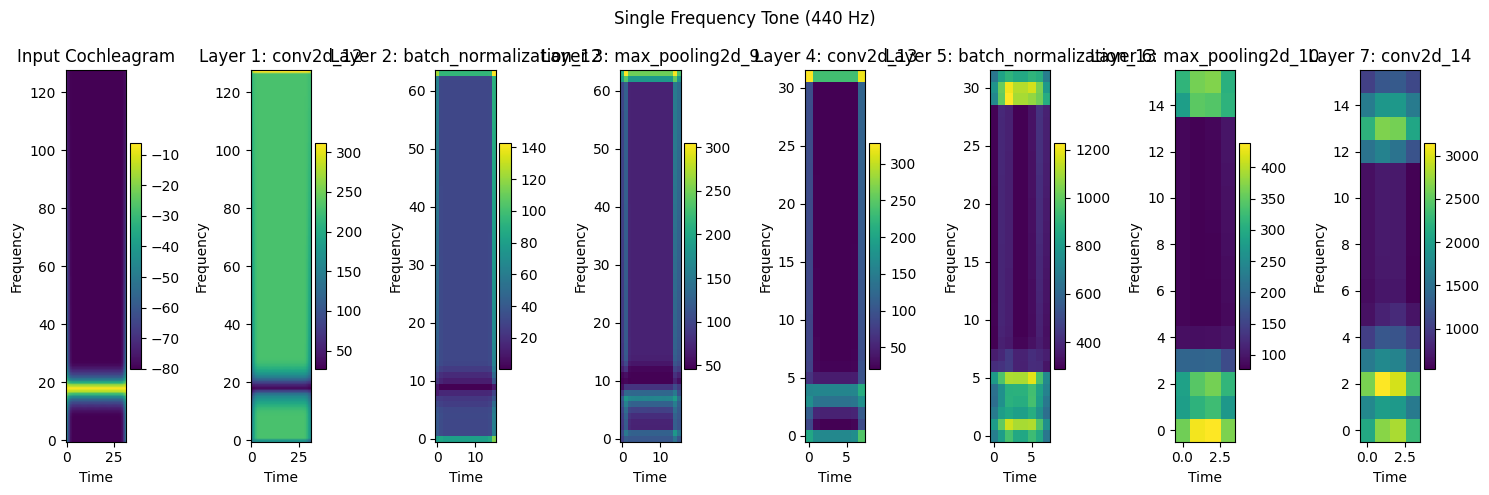

Visualizing: Amplitude Modulated Tone (Carrier: 440 Hz, Modulator: 5 Hz)
1/1 [==============================] - 0s 37ms/step


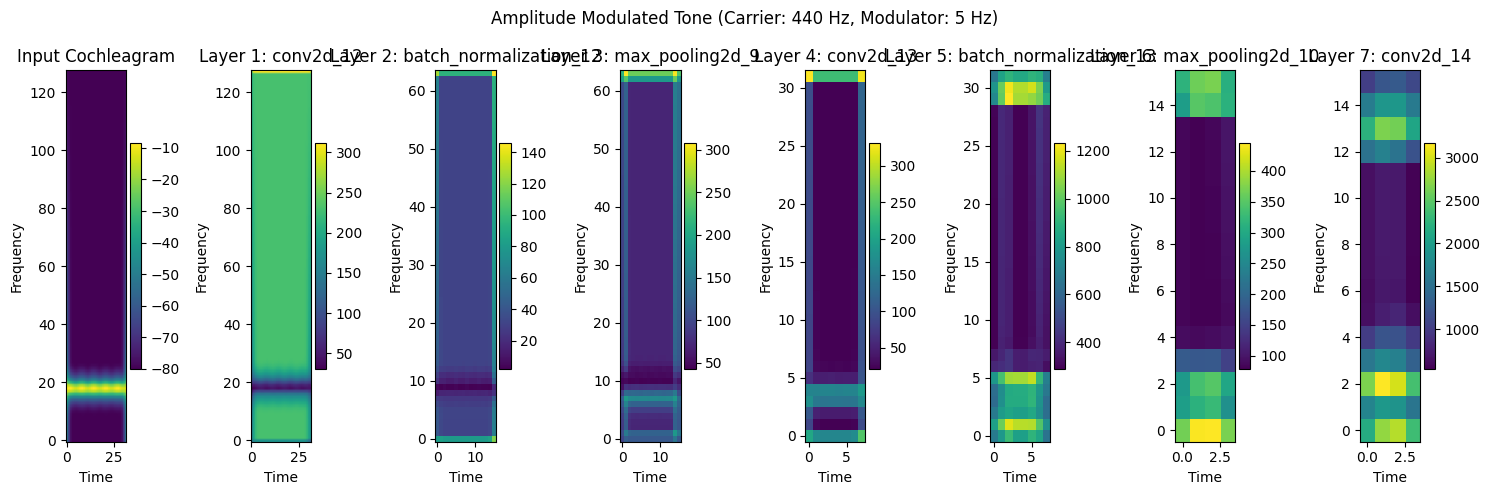

Visualizing: Frequency Modulated Tone (Carrier: 440 Hz, Modulator: 5 Hz)
1/1 [==============================] - 0s 35ms/step


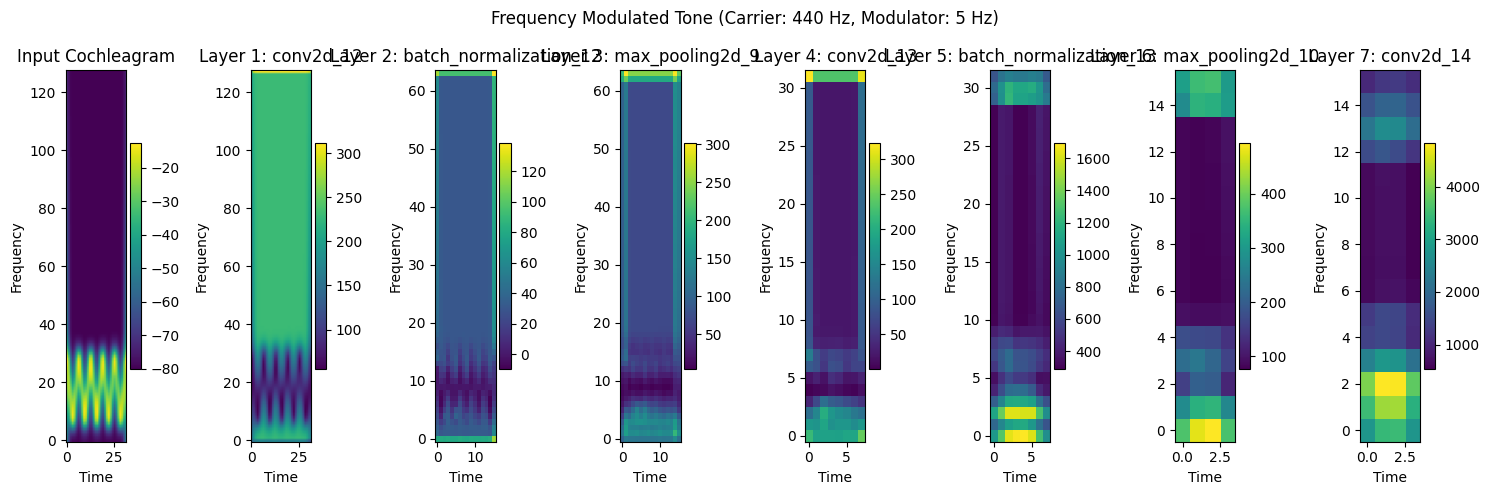

Visualizing: White Noise
1/1 [==============================] - 0s 35ms/step


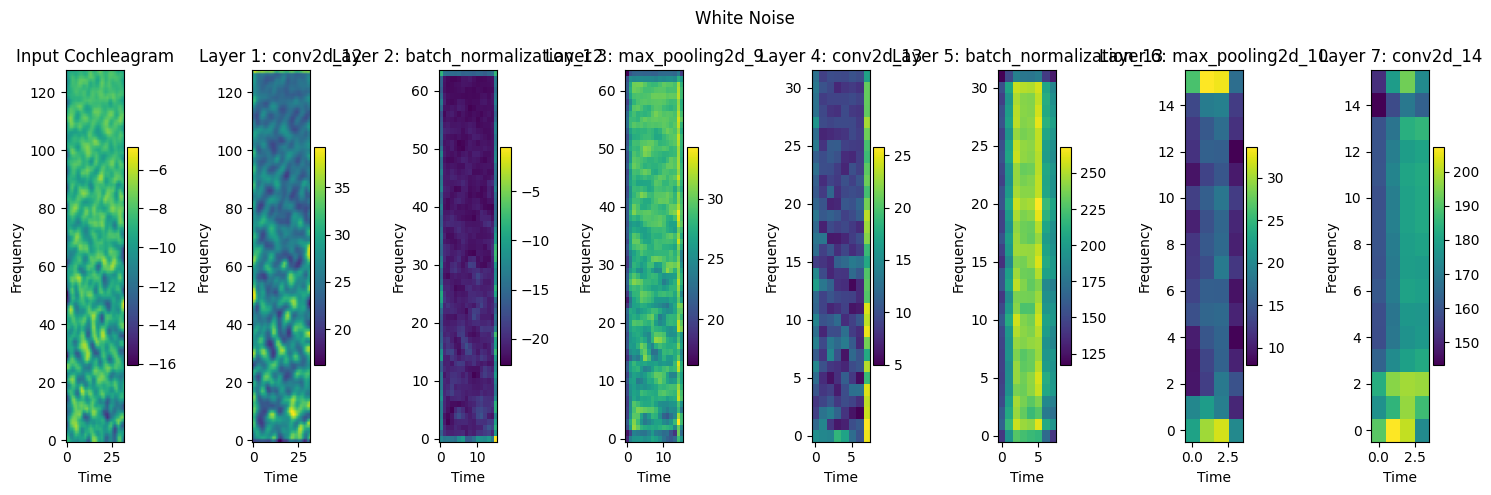

Visualizing: Harmonic Series (Fundamental: 220 Hz, 5 Harmonics)
1/1 [==============================] - 0s 34ms/step


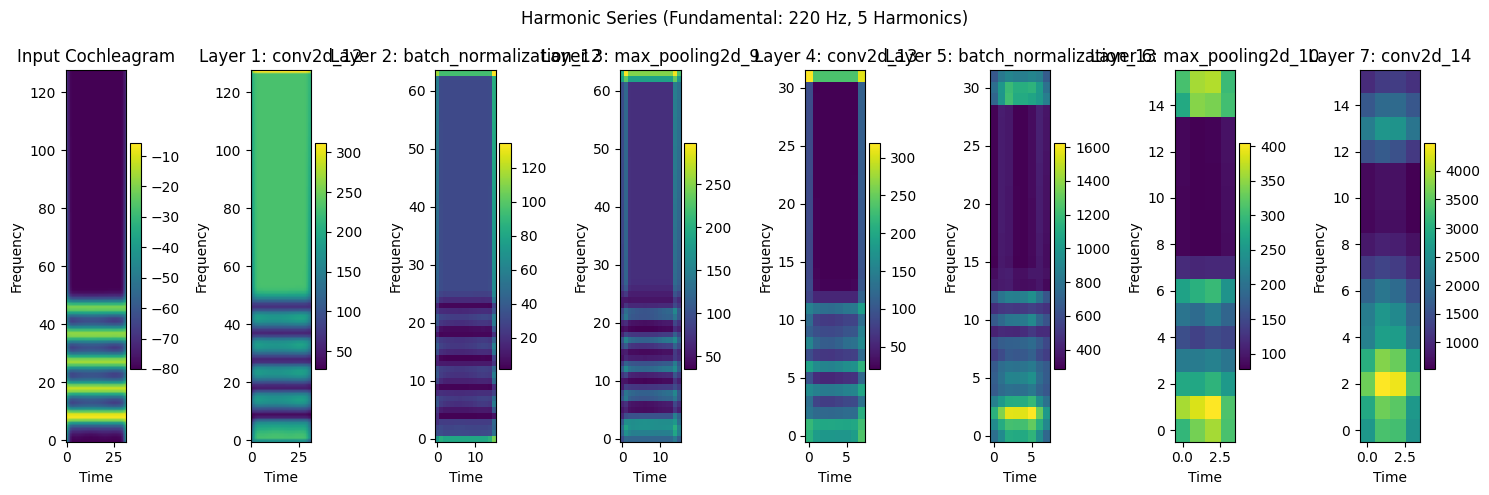

Visualizing: Frequency Sweep Up (200 Hz to 800 Hz)
1/1 [==============================] - 0s 33ms/step


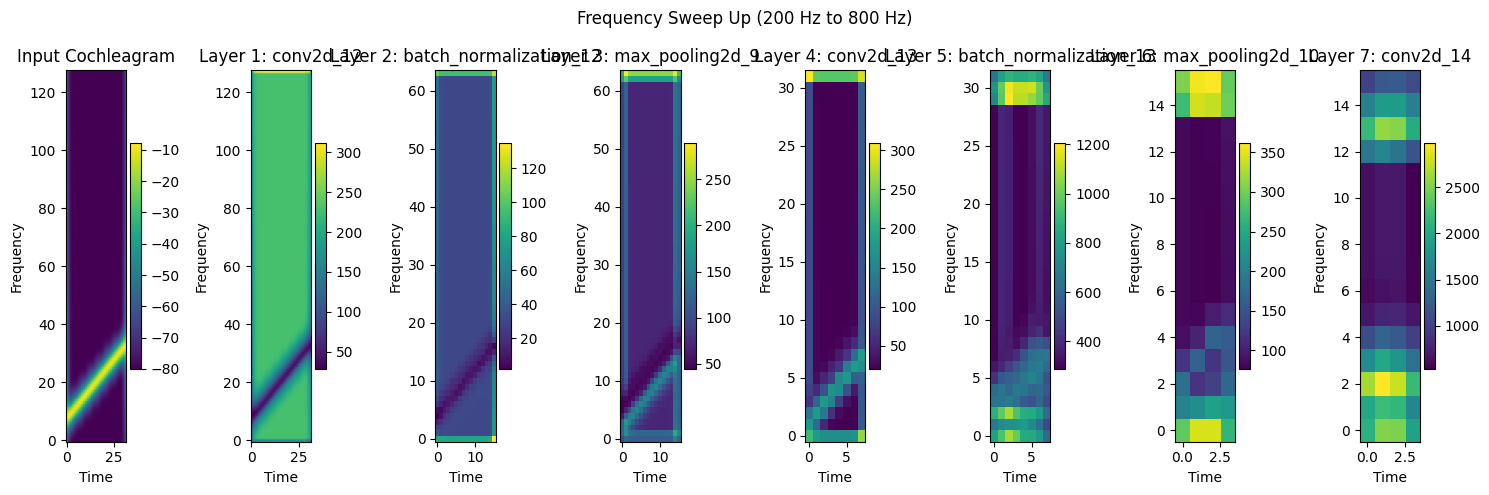

Visualizing: Frequency Sweep Down (800 Hz to 200 Hz)
1/1 [==============================] - 0s 33ms/step


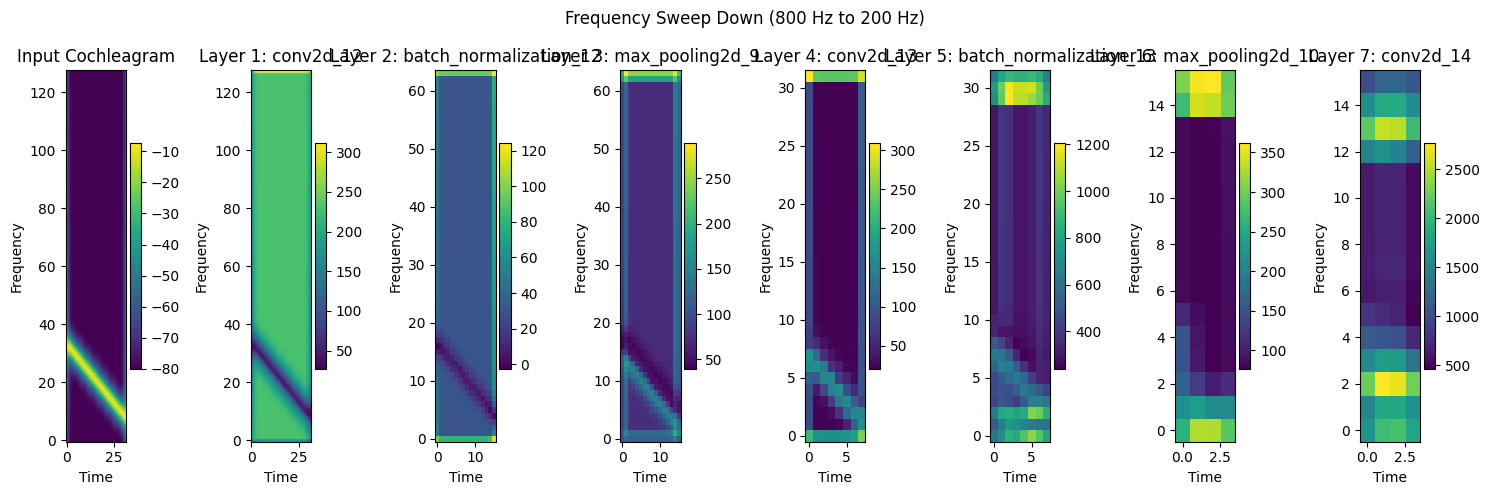

In [56]:
for pattern in patterns:
    print(f"Visualizing: {pattern['name']}")
    visualize_activations(pattern['signal'], title=pattern['name'])

Visualizing: Single Frequency Tone (440 Hz)
1/1 [==============================] - 0s 326ms/step


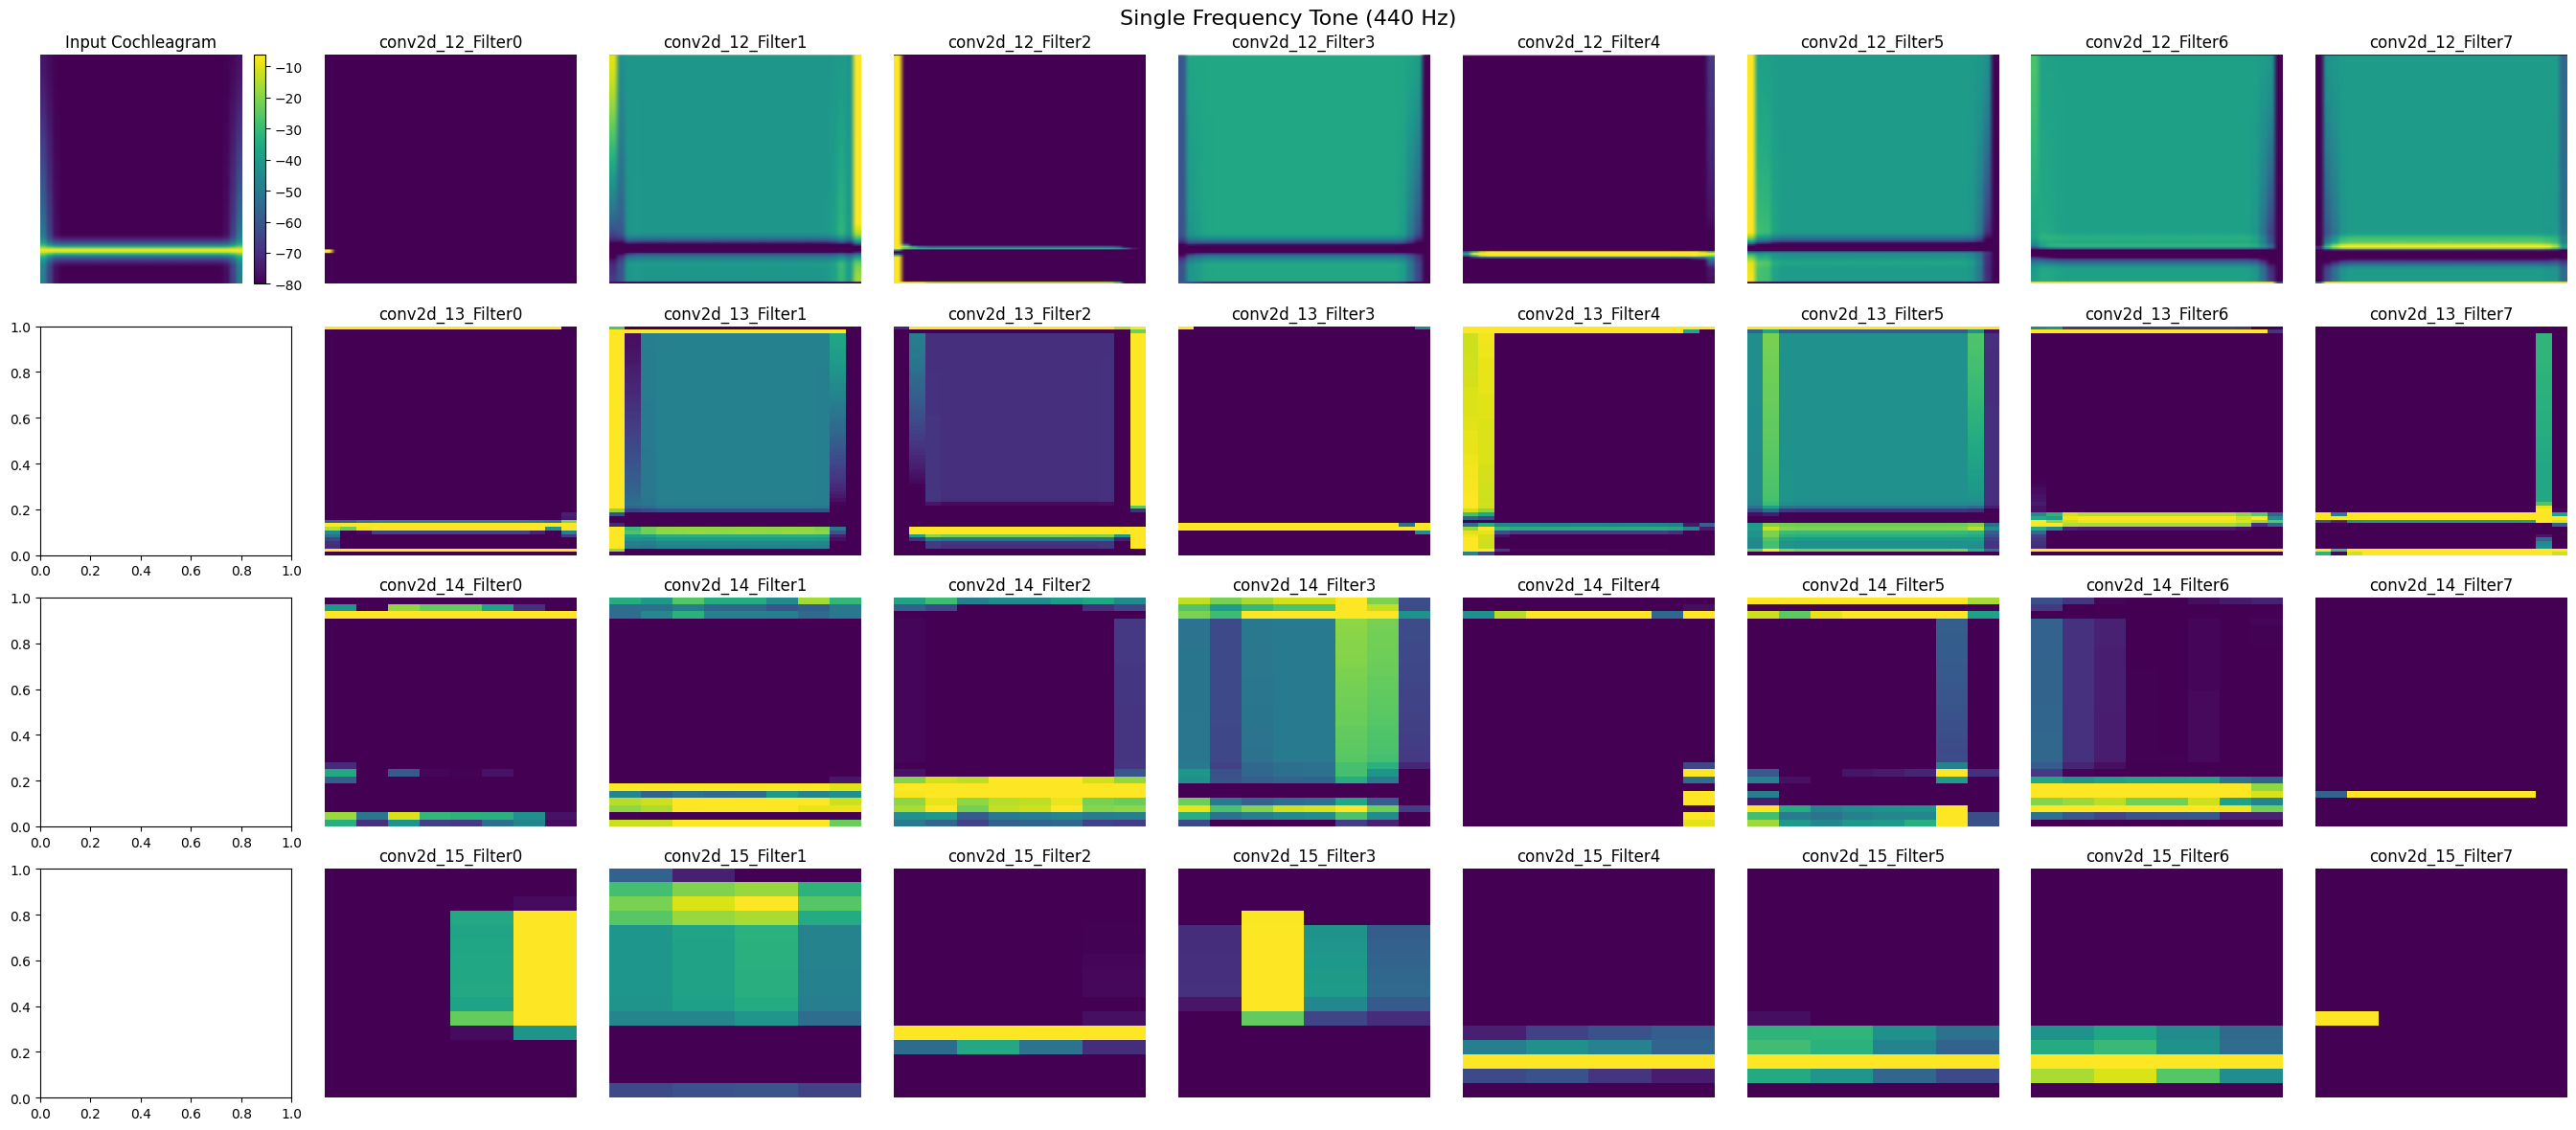

Visualizing: Amplitude Modulated Tone (Carrier: 440 Hz, Modulator: 5 Hz)
1/1 [==============================] - 0s 302ms/step


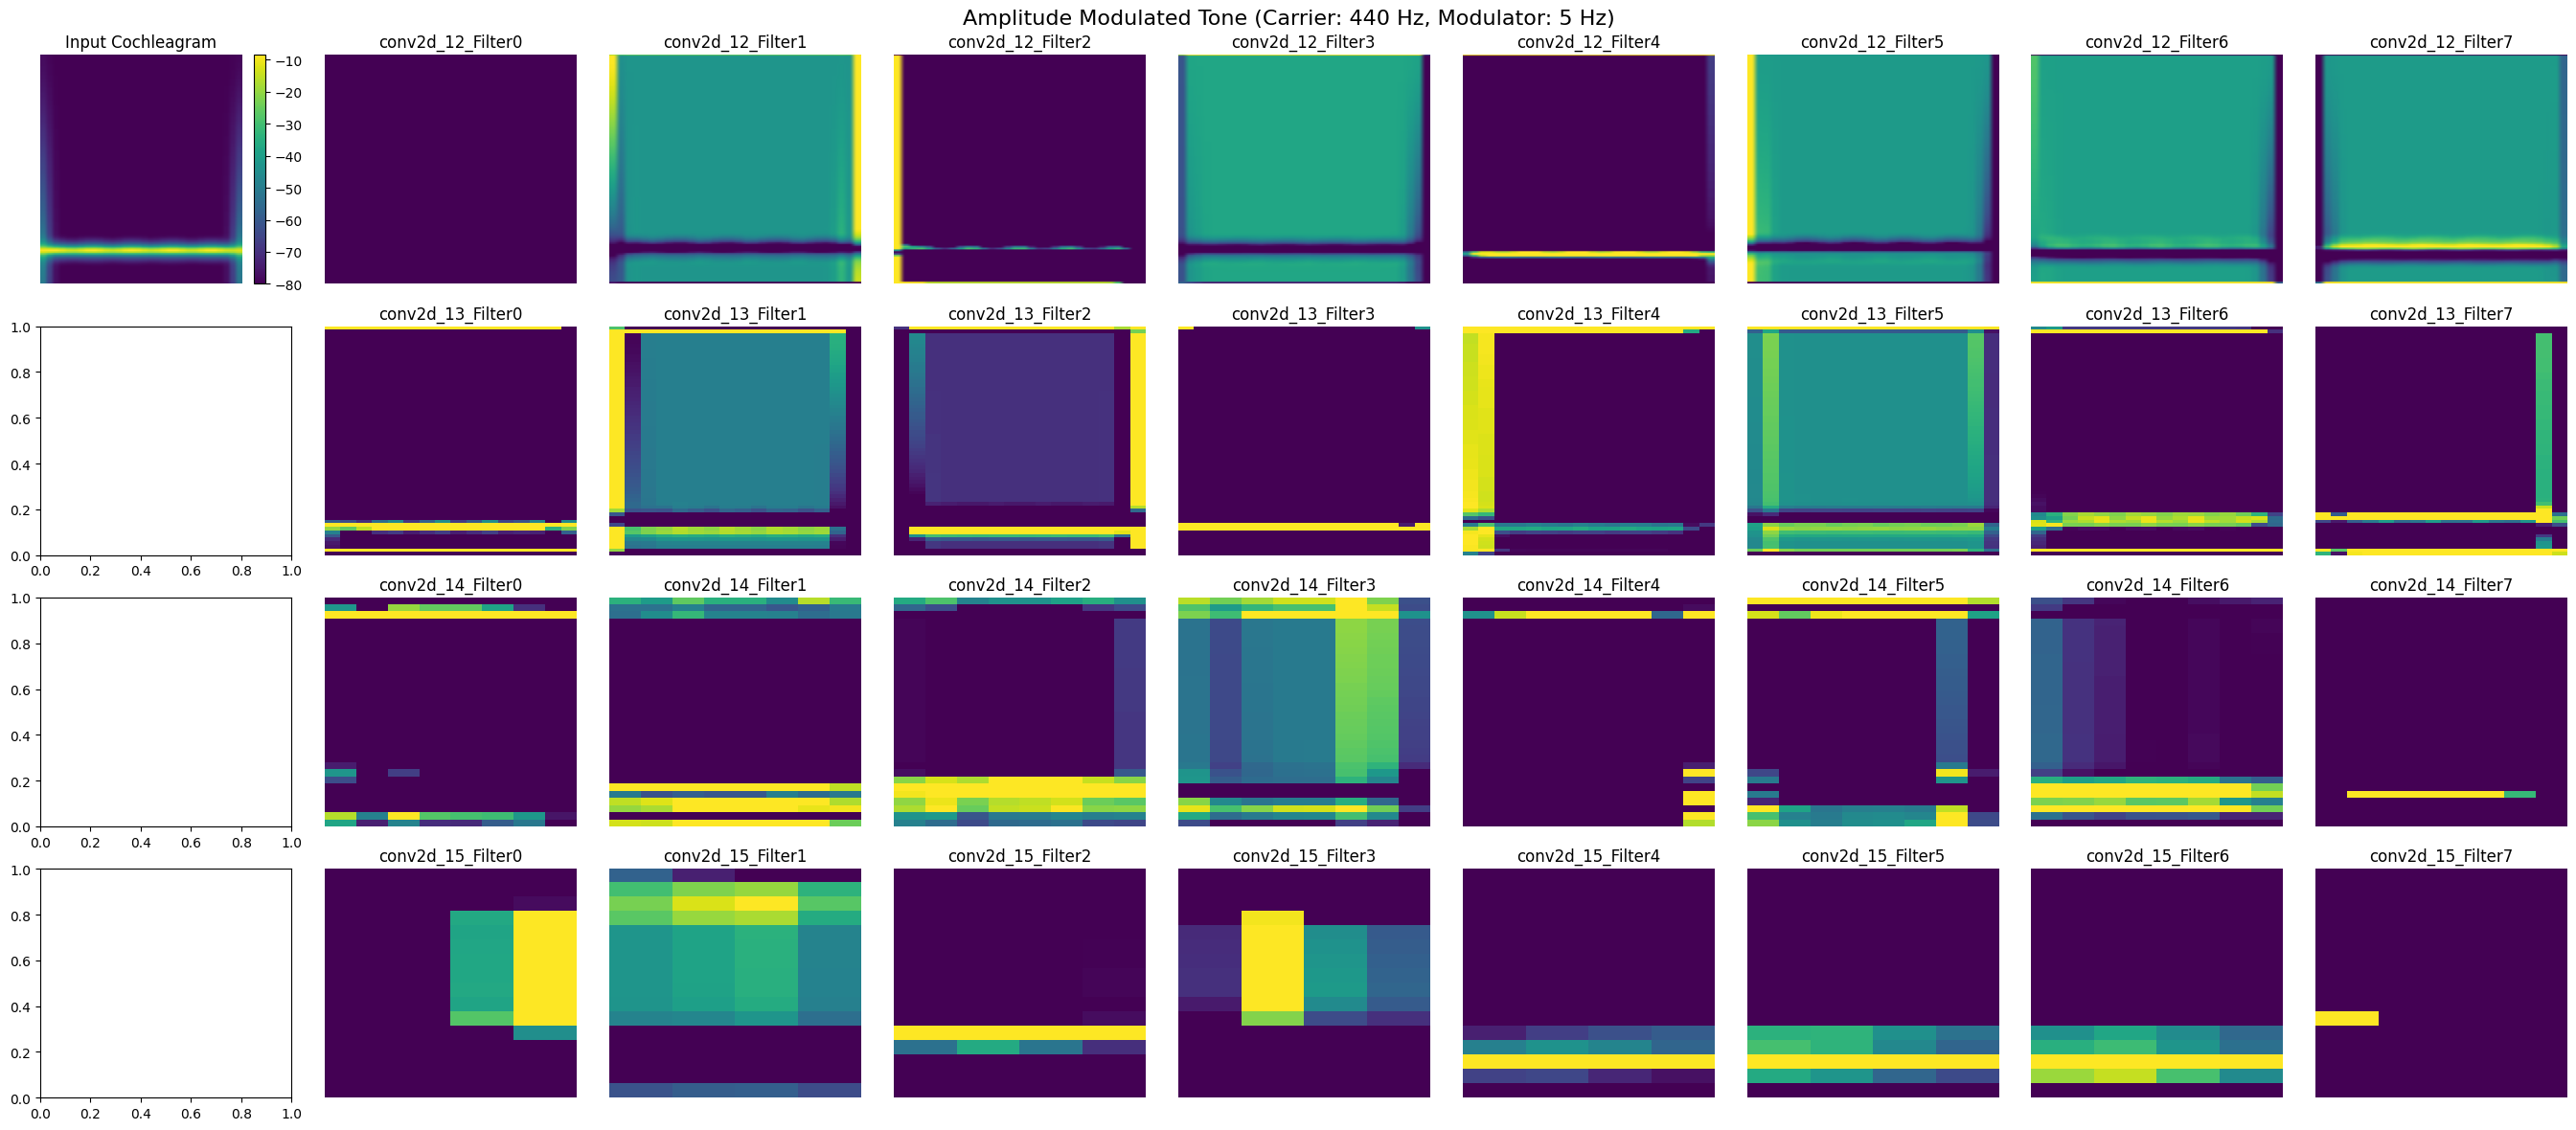

Visualizing: Frequency Modulated Tone (Carrier: 440 Hz, Modulator: 5 Hz)
1/1 [==============================] - 0s 290ms/step


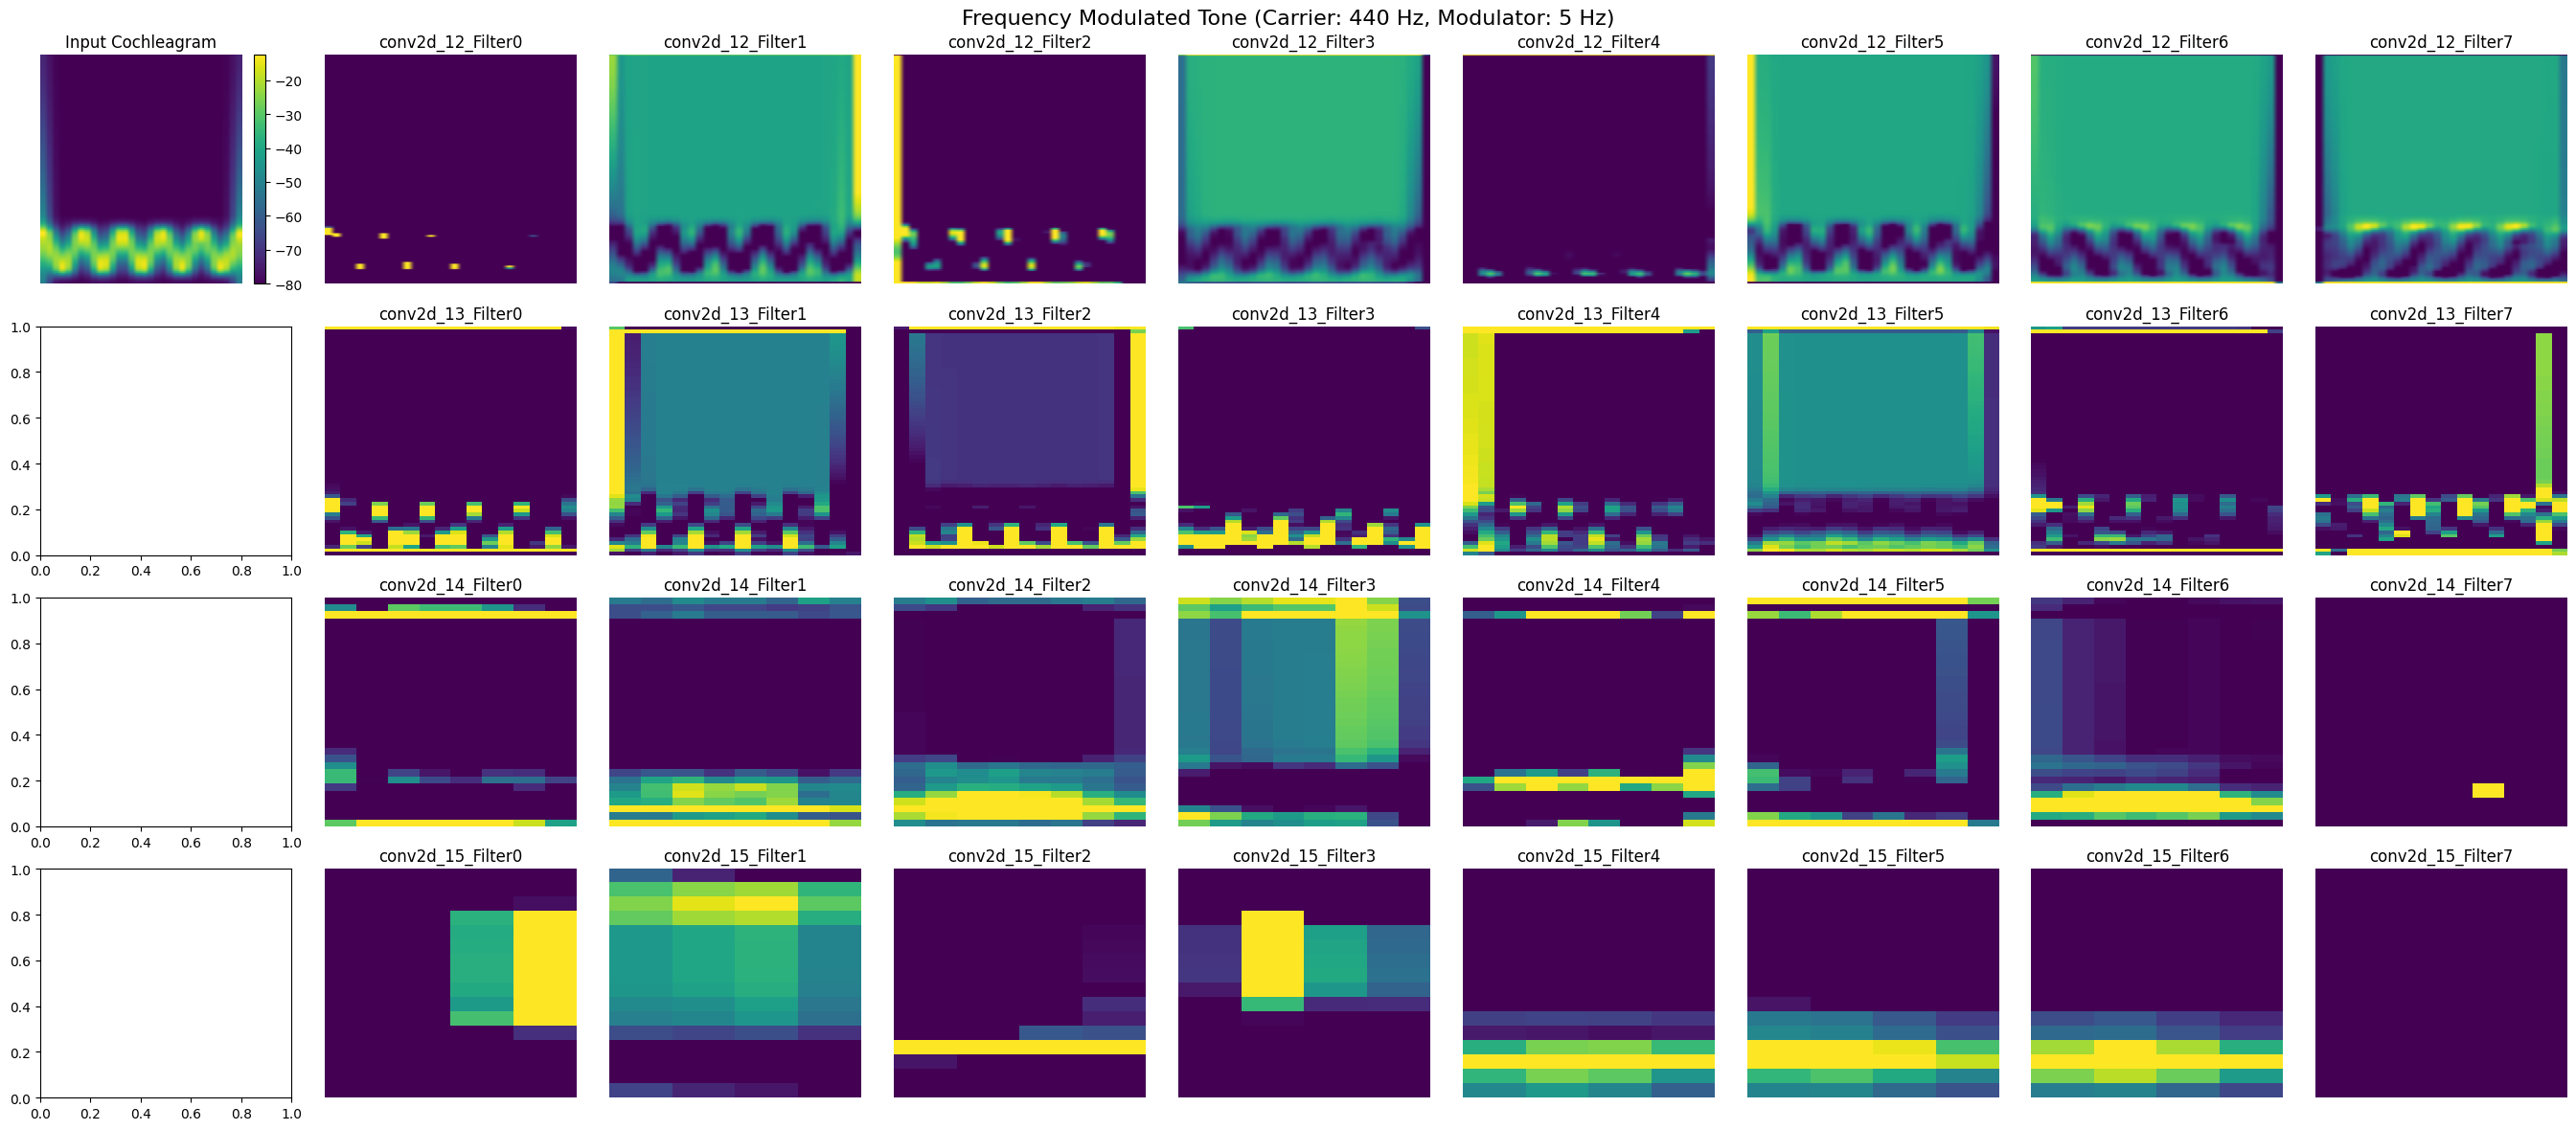

Visualizing: White Noise
1/1 [==============================] - 0s 277ms/step


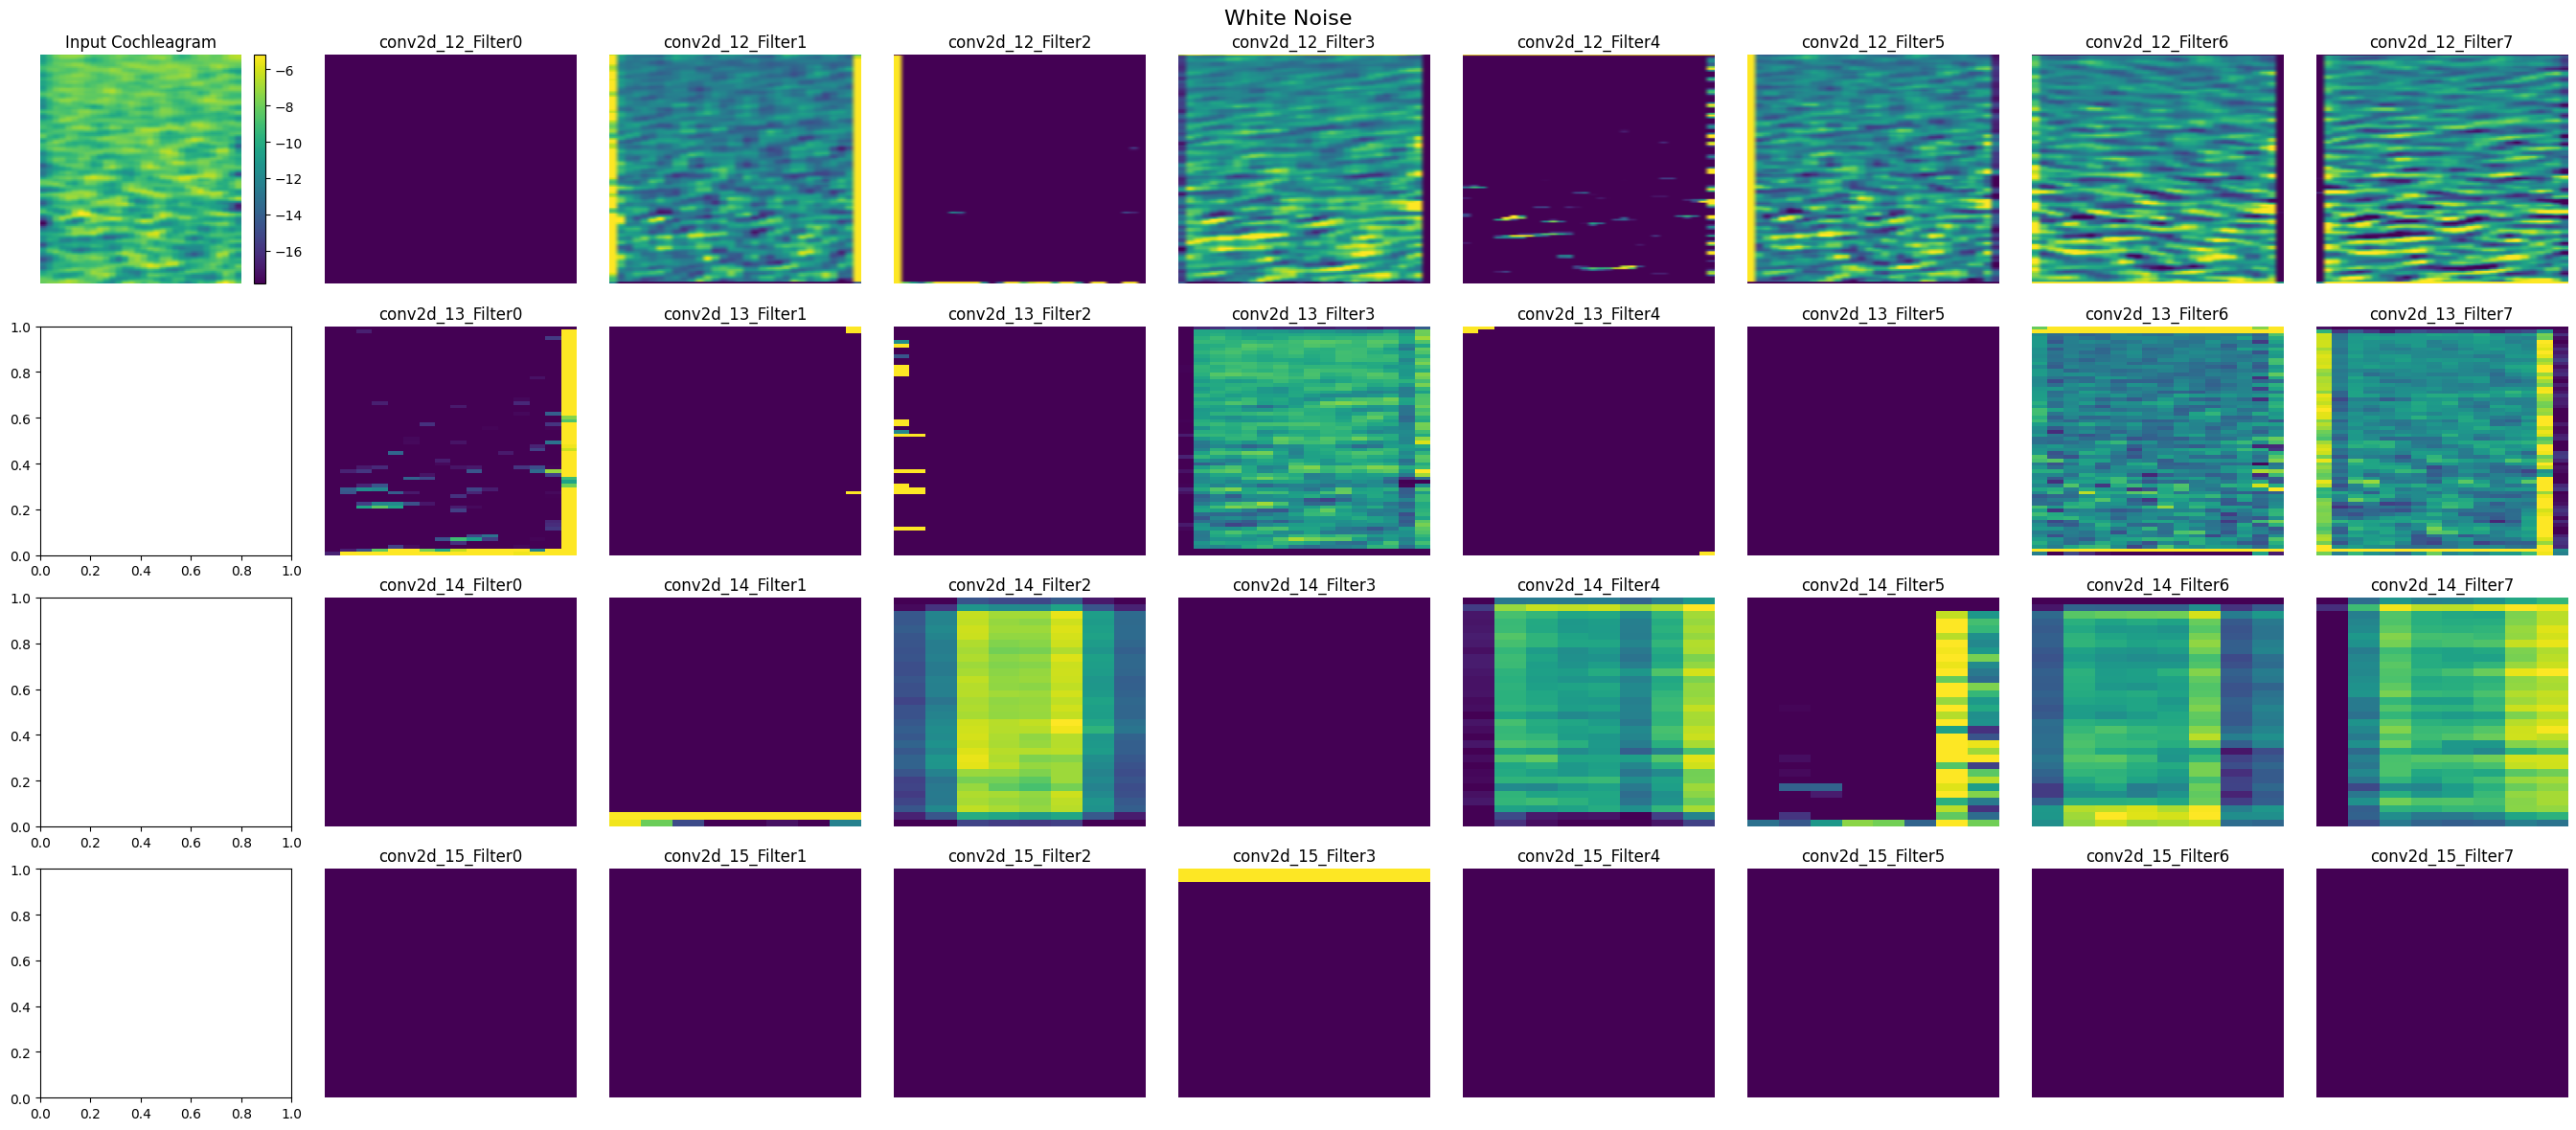

Visualizing: Harmonic Series (Fundamental: 220 Hz, 5 Harmonics)
1/1 [==============================] - 0s 301ms/step


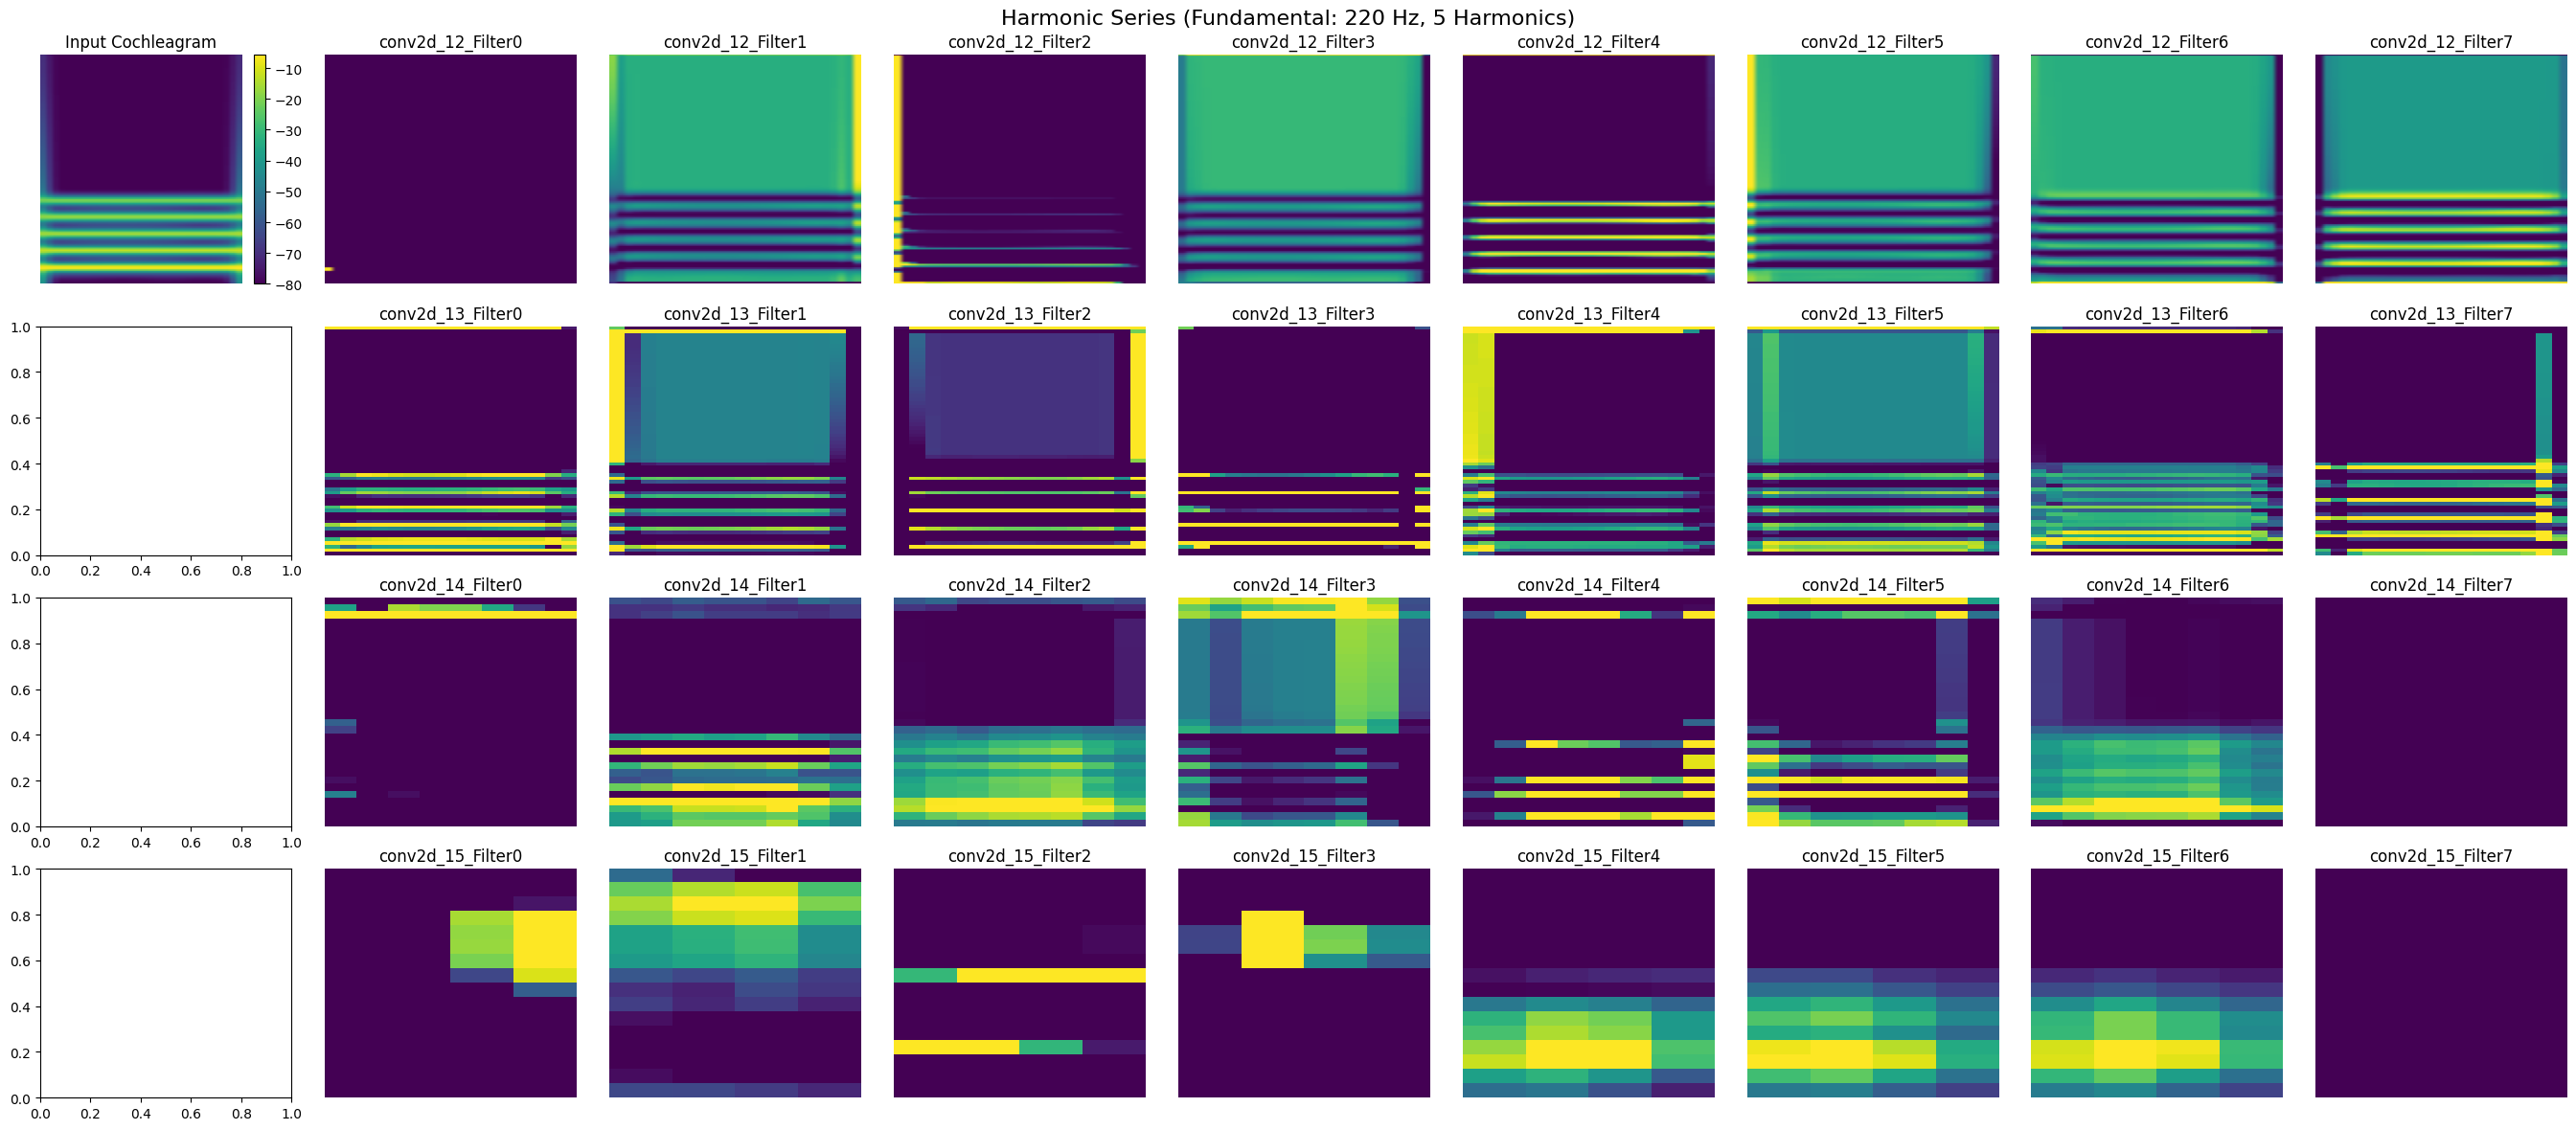

Visualizing: Frequency Sweep Up (200 Hz to 800 Hz)
1/1 [==============================] - 0s 307ms/step


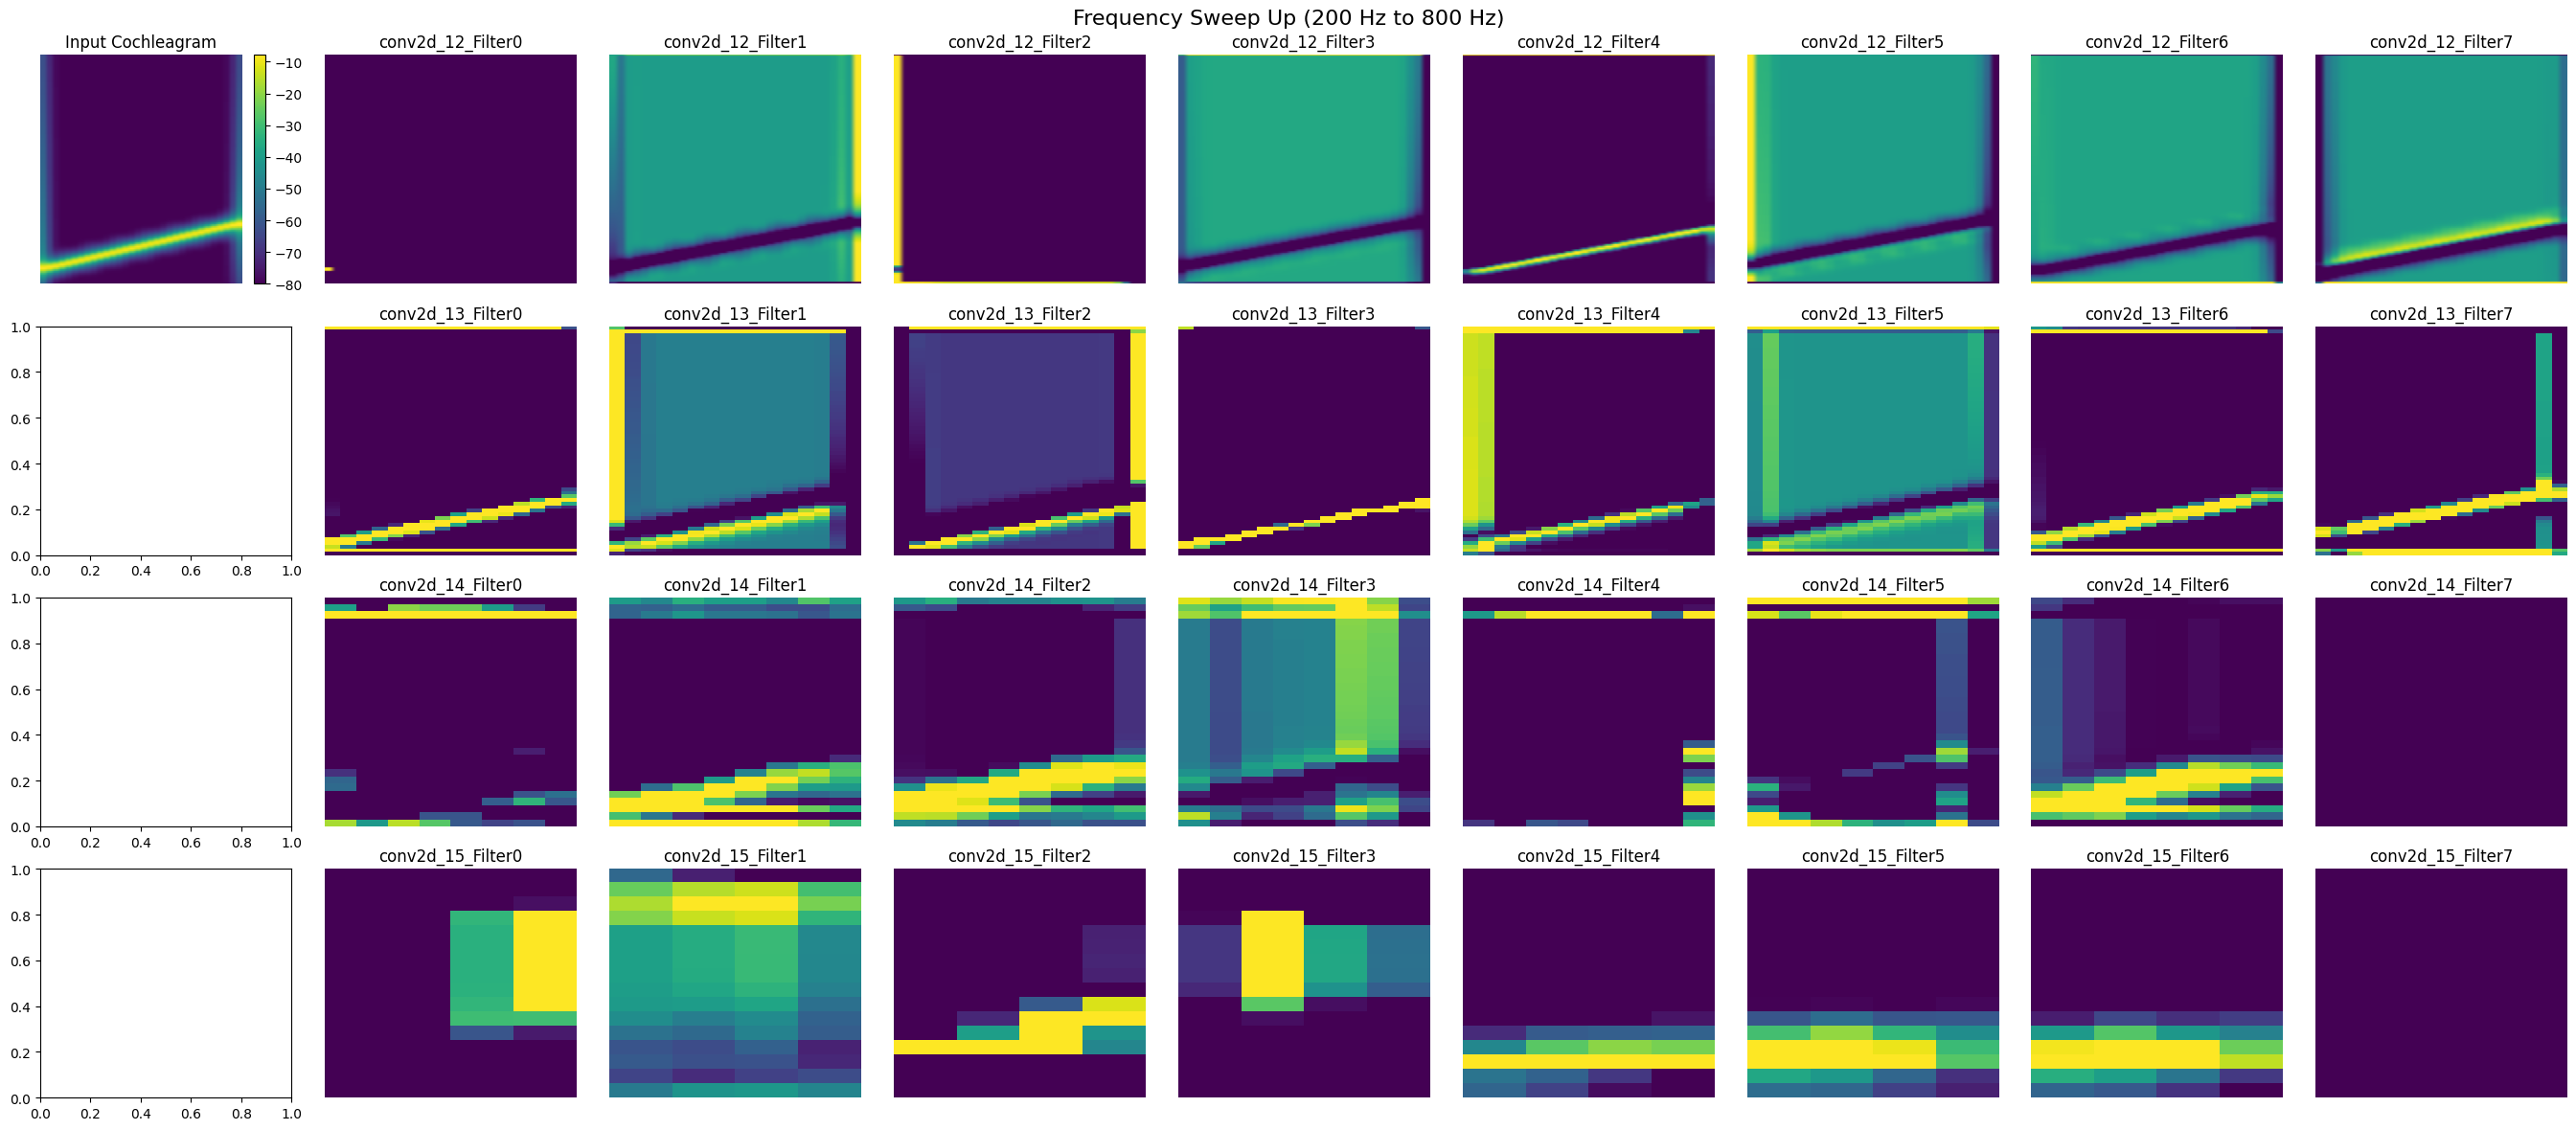

Visualizing: Frequency Sweep Down (800 Hz to 200 Hz)
1/1 [==============================] - 0s 302ms/step


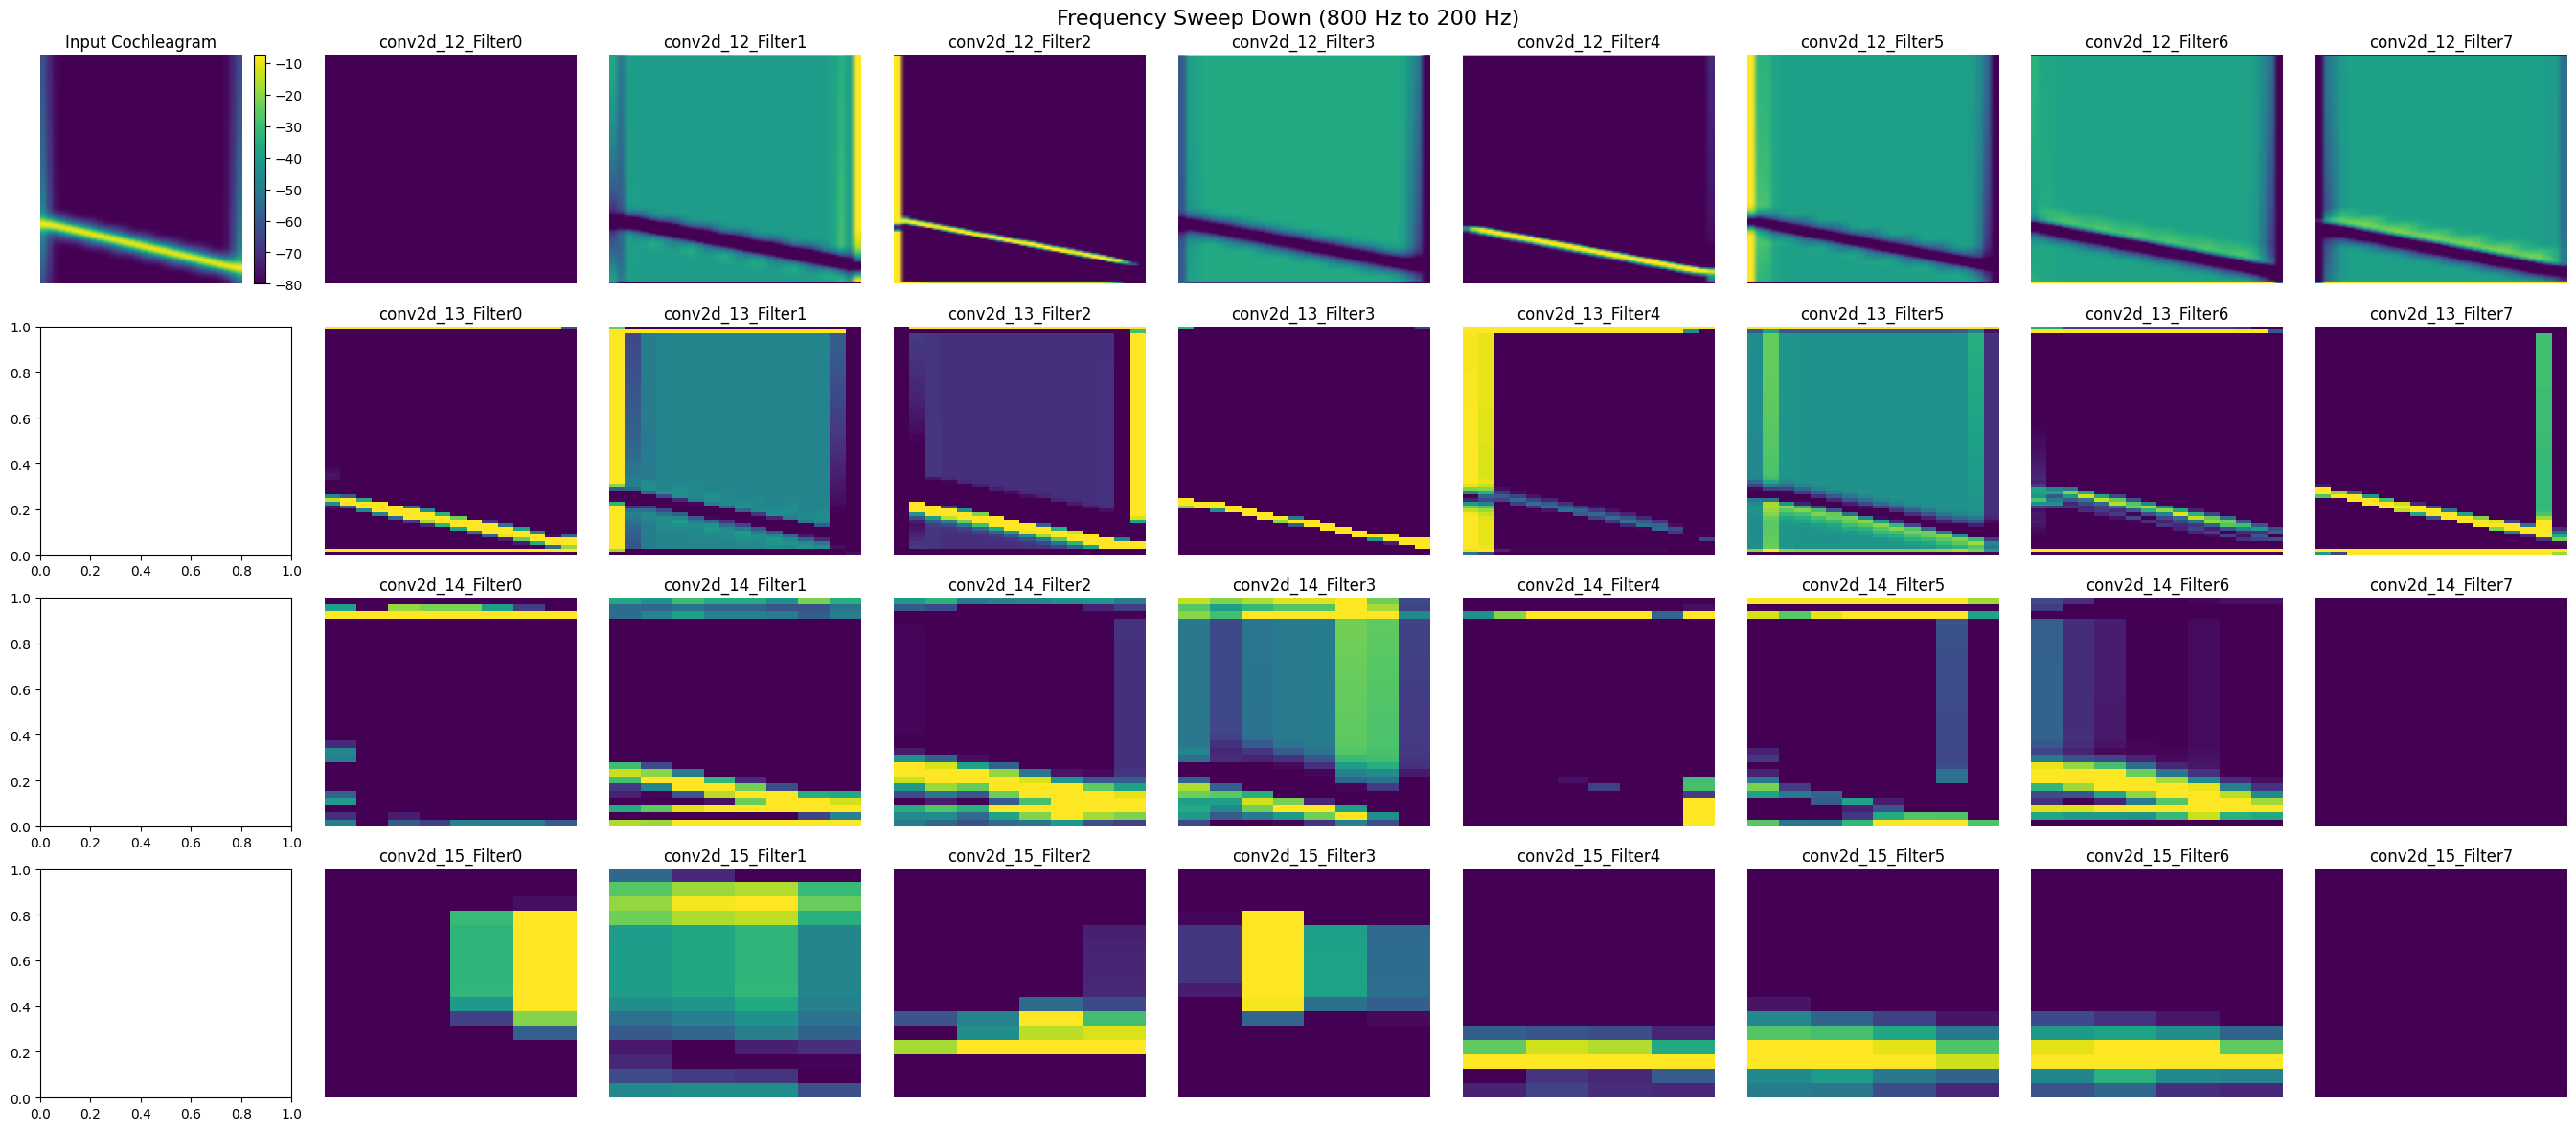

In [58]:
for pattern in patterns:
    print(f"Visualizing: {pattern['name']}")
    visualize_individual_filters(pattern['signal'], title=pattern['name'], num_filters=8)  